In [154]:
%matplotlib inline

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn import preprocessing as preproc, datasets, linear_model
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr

toolb = base.Toolbox()
pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)

# Data Preprocessing

In [155]:
url = 'https://blockchain.info/charts/%s?timespan=all&format=csv'
charts = ['market-price',
          'market-cap', 
          'transaction-fees-usd', 
          'n-transactions', 
          'n-unique-addresses', 
          'n-transactions-per-block',
          'n-orphaned-blocks',
          'output-volume',
          'estimated-transaction-volume-usd',
          'trade-volume',
          'tx-trade-ratio',
          'cost-per-transaction',
          'hash-rate',
          'difficulty',
          'miners-revenue',
          'median-confirmation-time',
          'bitcoin-days-destroyed',
          'avg-block-size'
         ]

frames = []   # contains everything as dataframes from charts
features = [] # contains everything as dataframes from charts except the market-price, values are standardized

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

data = pd.read_csv(url % charts[0], parse_dates=[0], date_parser = dateparse)
data.columns = ['date', charts[0]]
    
df = pd.DataFrame(data)
df['date'] = df['date'].apply(lambda x: x.date())
df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = '1/4/2012', end = '4/10/2016'))
frames.append(df)

for chart in charts[1:]:
    data = pd.read_csv(url % chart, parse_dates=[0], date_parser = dateparse)
    data.columns = ['date', chart]
    
    df = pd.DataFrame(data)
    df['date'] = df['date'].apply(lambda x: x.date())
    df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = '1/4/2012', end = '4/10/2016'))
    frames.append(df)
    
    data_np = df.as_matrix()
    scaler = preproc.StandardScaler().fit(data_np)
    data_np_standard = scaler.transform(data_np)
    
    df_standard = pd.DataFrame(data=data_np_standard, index=df.index, columns=df.columns)
    features.append(df_standard)
    
#btc_dataset = pd.DataFrame(data=features)
#btc_dataset = btc_dataset.set_index('market-price')

# Linear Regression with R<sup>2</sup> statistic fitness function

In [156]:
def filterFeatures (mask):
    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, features))))

def fitnessFun (indiv):
    if(sum(indiv) == 0):
        indiv[0] = 1
    
    filteredFeatures = filterFeatures(indiv)
    size = len(filteredFeatures)
    features = pd.concat(filteredFeatures, axis = 1)
    btc_features = pd.DataFrame(features.values).as_matrix()
    btc_target = pd.DataFrame(frames[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing. 

    btc_X_train = btc_features[:int(0.6*len(btc_features))]
    btc_X_validation = btc_features[int(0.6*len(btc_features)):int(0.8*len(btc_features))]

    btc_y_train = btc_target[:int(0.6*len(btc_target))]
    btc_y_validation = btc_target[int(0.6*len(btc_target)):int(0.8*len(btc_target))]

    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    print ('Variance score: %.9f, %d' % (regr.score(btc_X_validation, btc_y_validation), size))
    #plt.scatter(size, regr.score(btc_X_test, btc_y_test), marker='.')
    
    return regr.score(btc_X_validation, btc_y_validation), size

creator.create("FitnessMulti", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti) 

# MOEA-MLR with R<sup>2</sup> Statistics

Variance score: 0.563825704, 13
Variance score: 0.482553501, 5
Variance score: 0.256910085, 9
Variance score: 0.778746954, 8
Variance score: 0.036999526, 8
Variance score: -106.839485803, 2
Variance score: 0.723422958, 13
Variance score: 0.612245671, 9
Variance score: -82.131078973, 9
Variance score: 0.614878060, 11
Variance score: 0.566478103, 10
Variance score: 0.605710803, 3
Variance score: -2.840997063, 9
Variance score: 0.643594822, 11
Variance score: 0.986316509, 8
Variance score: 0.643015591, 7
Variance score: 0.361976645, 10
Variance score: -7.379819991, 11
Variance score: -84.426156688, 7
Variance score: -93.487612876, 5
Variance score: -1.636034876, 10
Variance score: -3.689654629, 11
Variance score: 0.668554822, 7
Variance score: -6.564032075, 9
Variance score: 0.624186862, 9
Variance score: -1.604918800, 13
Variance score: -121.223200563, 5
Variance score: -2.773174883, 7
Variance score: 0.883643195, 7
Variance score: -11.704918454, 9
Variance score: 0.704412025, 8
Variance

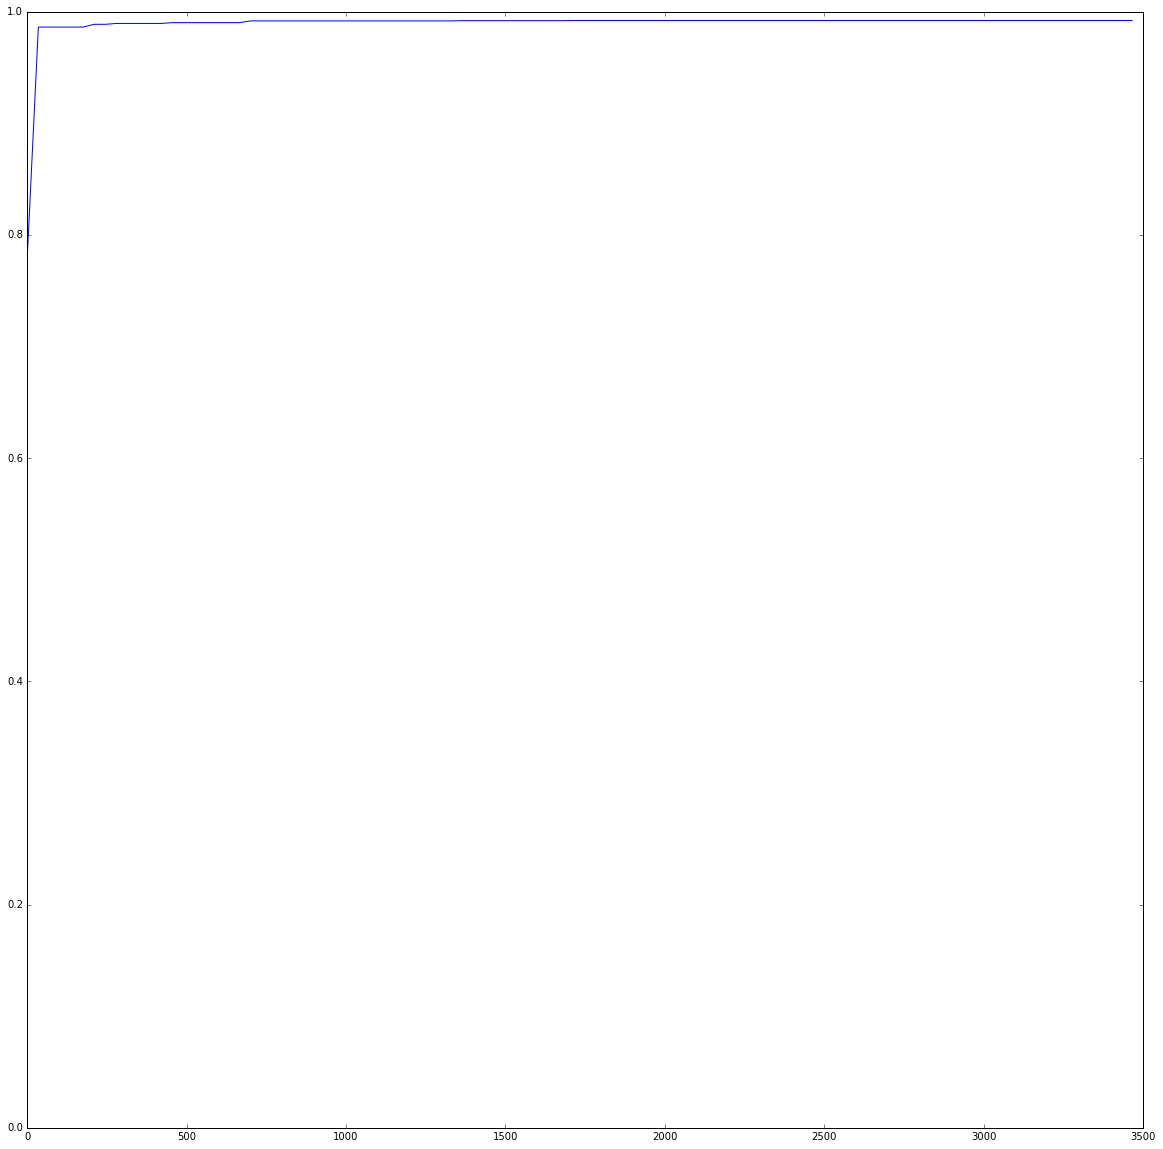

In [157]:
# Concatenate the features in order to group them by date
gens = 100
indiv_num = 35

toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(features))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
toolb.register('evaluate', fitnessFun)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

population = toolb.population()
fits = map (toolb.evaluate, population)
hof = tools.HallOfFame(1)

for fit, ind in zip(fits, population):
    ind.fitness.values = fit

plt.ylim([0,1])
fig = plt.gcf()
fig.set_size_inches(20,20)

best = np.ndarray((gens, 1))

for gen in range(gens):
    offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
    hof.update(offspring)
    fits = map (toolb.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = indiv_num)
    print(hof[0].fitness.values)
    best[gen] = hof[0].fitness.values[0]

x = list(range(0, indiv_num * gens, indiv_num))
plt.plot(x, best)
print (list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], charts[1:])))))

# Linear Regression with RMSE fitness function

In [158]:
def fitnessFun (indiv):
    if(sum(indiv) == 0):
        indiv[0] = 1
    filteredFeatures = filterFeatures(indiv)
    
    size = len(filteredFeatures)
    features = pd.concat(filteredFeatures, axis = 1)
    btc_features = pd.DataFrame(features.values).as_matrix()
    btc_target = pd.DataFrame(frames[0]).as_matrix().flatten()
    
    # 60% of the data will be used for training,
    # 20% will be used for validation and testing. 

    btc_X_train = btc_features[:int(0.6*len(btc_features))]
    btc_X_validation = btc_features[int(0.6*len(btc_features)):int(0.8*len(btc_features))]

    btc_y_train = btc_target[:int(0.6*len(btc_target))]
    btc_y_validation = btc_target[int(0.6*len(btc_target)):int(0.8*len(btc_target))]

    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    print ('RMSE: %.9f, %d' % (math.sqrt(mse(btc_y_validation, regr.predict(btc_X_validation))), size))
    
    return math.sqrt(mse(btc_y_validation, regr.predict(btc_X_validation))), size

creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

# MOEA-MLR with RMSE

RMSE: 56.277901290, 11
RMSE: 54.369460256, 10
RMSE: 63.001696241, 9
RMSE: 181.506093333, 9
RMSE: 59.365248879, 11
RMSE: 416.016271286, 5
RMSE: 14.315584448, 9
RMSE: 397.484418219, 9
RMSE: 440.296607648, 8
RMSE: 309.232287327, 7
RMSE: 24.460930430, 6
RMSE: 66.031439468, 11
RMSE: 265.170093674, 9
RMSE: 56.134890297, 7
RMSE: 94.594339467, 6
RMSE: 57.496000262, 12
RMSE: 504.944809666, 8
RMSE: 61.399797432, 9
RMSE: 111.965187313, 8
RMSE: 125.296908106, 10
RMSE: 647.908941301, 6
RMSE: 59.699935481, 8
RMSE: 54.403475522, 12
RMSE: 260.225362588, 3
RMSE: 64.018248724, 9
RMSE: 57.234098131, 11
RMSE: 206.487789712, 7
RMSE: 103.774191693, 10
RMSE: 314.880315298, 11
RMSE: 162.830319488, 12
RMSE: 439.125169627, 5
RMSE: 110.756791131, 5
RMSE: 36.293669676, 7
RMSE: 68.096759962, 11
RMSE: 540.128034436, 8
RMSE: 57.234098131, 11
RMSE: 54.369460256, 10
RMSE: 647.908941301, 6
RMSE: 46.998374304, 7
RMSE: 647.908941301, 6
RMSE: 61.399797432, 9
RMSE: 54.299008483, 11
RMSE: 64.370421675, 13
RMSE: 61.399797432

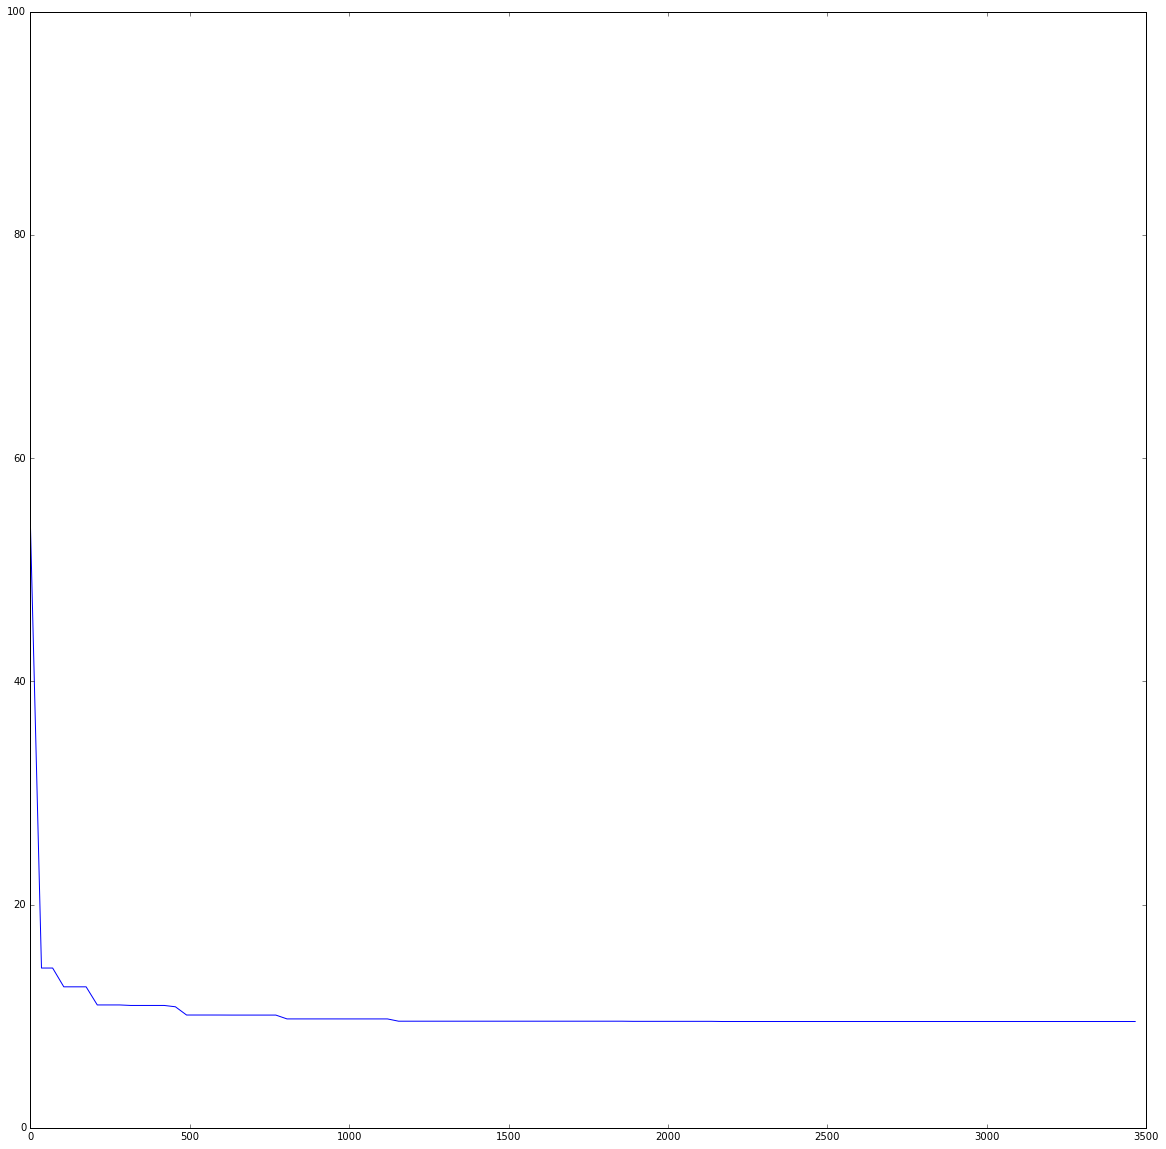

In [159]:
# Concatenate the features in order to group them by date
gens = 100
indiv_num = 35

toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(features))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
toolb.register('evaluate', fitnessFun)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

population = toolb.population()
fits = map (toolb.evaluate, population)
hof = tools.HallOfFame(1)

for fit, ind in zip(fits, population):
    ind.fitness.values = fit

plt.ylim([0,100])
fig = plt.gcf()
fig.set_size_inches(20,20)

best = np.ndarray((gens, 1))

for gen in range(gens):
    offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.5, mutpb = 0.1)
    hof.update(offspring)
    fits = map (toolb.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = indiv_num)
    print(hof[0].fitness.values)
    best[gen] = hof[0].fitness.values[0]

x = list(range(0, indiv_num * gens, indiv_num))
plt.plot(x, best)
print (list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], charts[1:])))))

# Visualizing the actual and predicted prices 

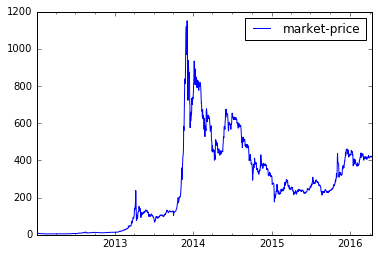

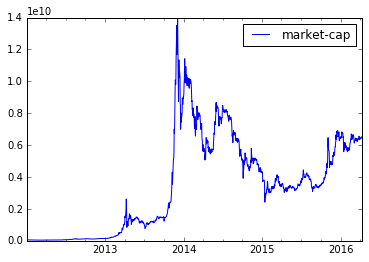

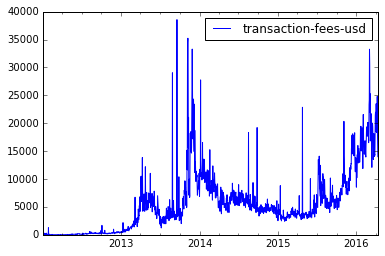

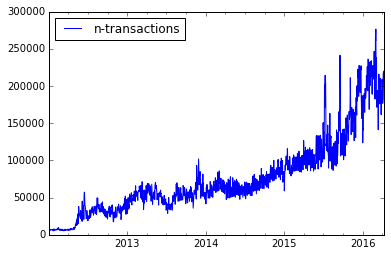

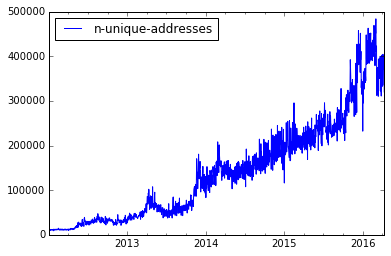

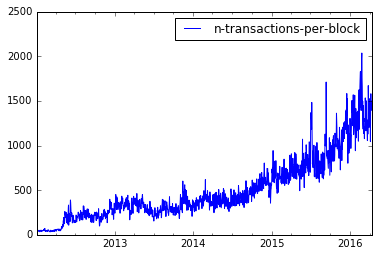

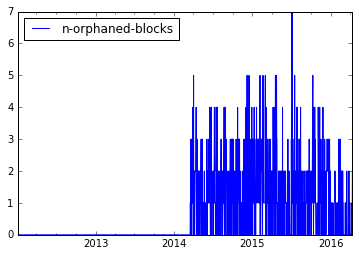

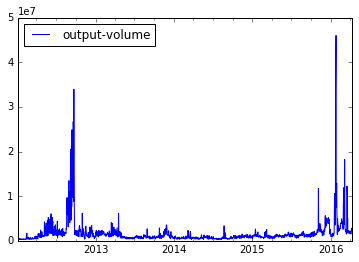

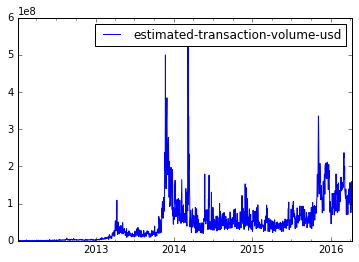

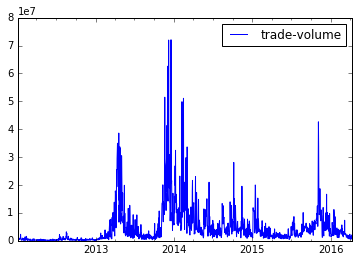

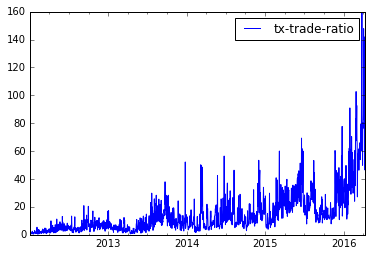

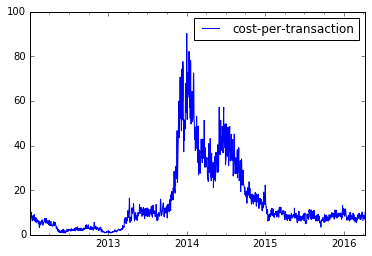

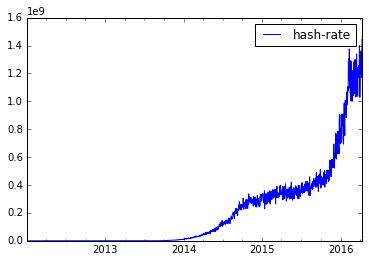

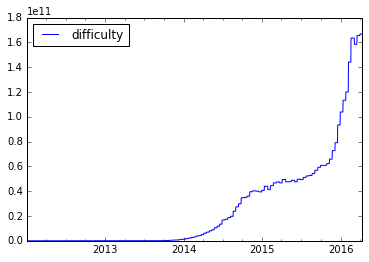

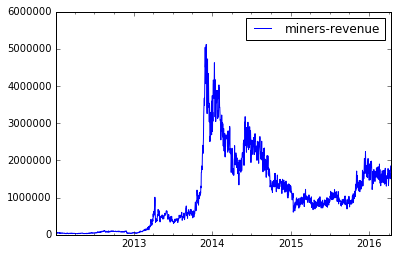

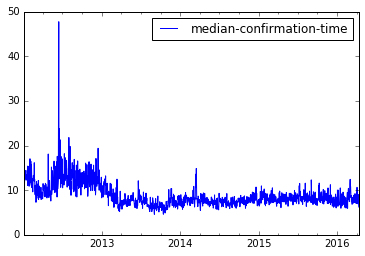

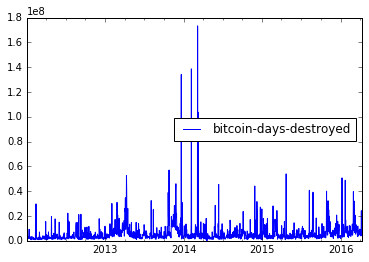

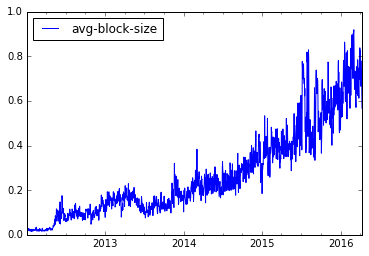

In [160]:
for f in frames:
    f.plot()
    

#features.plot(figsize = (25,25))


RMSE: 33.475360647
Variance score: 0.822988395


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and wil

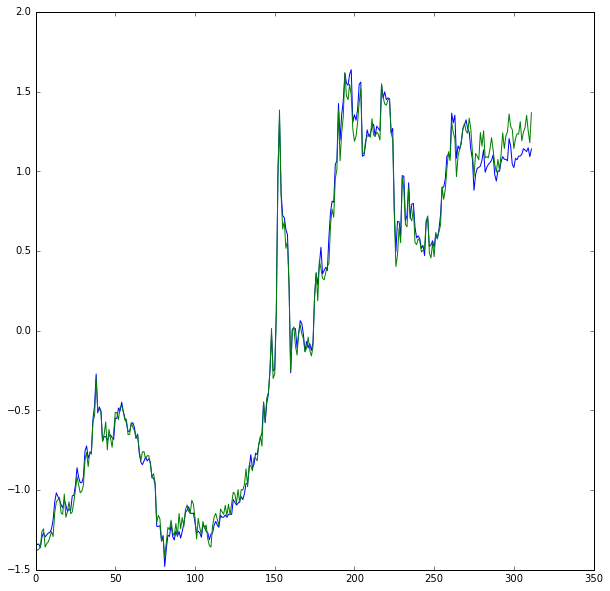

In [161]:
filteredFeatures = filterFeatures(hof[0])
filtered_features = pd.concat(filteredFeatures, axis = 1)
btc_features = pd.DataFrame(filtered_features.values).as_matrix()
btc_target = pd.DataFrame(frames[0]).as_matrix().flatten()

btc_X_train = btc_features[:int(0.6*len(btc_features))]
btc_X_validation = btc_features[int(0.6*len(btc_features)):int(0.8*len(btc_features))]

btc_y_train = btc_target[:int(0.6*len(btc_target))]
btc_y_validation = btc_target[int(0.6*len(btc_target)):int(0.8*len(btc_target))]

# Create the learner

regr = linear_model.LinearRegression()

# Train the learner on the training data
# and evaluate the performance by the test data

regr.fit(btc_X_train, btc_y_train)
btc_X_test = btc_features[int(0.8*len(btc_features)):]
btc_y_test = btc_target[int(0.8*len(btc_target)):]
scaler_act = preproc.StandardScaler().fit(btc_y_test)
scaler_pred = preproc.StandardScaler().fit(regr.predict(btc_X_test))
standardized_act = scaler_act.transform(btc_y_test)
standardize_pred = scaler_pred.transform(regr.predict(btc_X_test))


x = list(range(0, len(btc_y_test)))

plt.figure(figsize = (10,10))
plt.plot(x, standardized_act, label = 'Actual Prices')
plt.plot(x, standardize_pred, label = 'Predicted Prices')

print ('RMSE: %.9f' % (math.sqrt(mse(btc_y_test, regr.predict(btc_X_test)))))
print ('Variance score: %.9f' % (regr.score(btc_X_test, btc_y_test)))

# Price values

In [162]:
compare_df = pd.DataFrame(data = list(zip(btc_y_test, regr.predict(btc_X_test))), 
                          index = features.index[int(0.7*len(btc_target)):], 
                          columns = ['actual', 'predicted'])
compare_df

TypeError: 'builtin_function_or_method' object is not subscriptable